# Supervised Machine Learning Project code
### Raghav Rastogi

Techniques used are Convolution neural network and Logistic regression on CIFAR10 dataset and comparing the results


# Importing the libraries

In [ ]:
import torchvision
import torch
import numpy as np
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import time
import pandas as pd
import torchvision.datasets as datasets
from IPython import display
import matplotlib.pyplot as plt
import torchvision.transforms

# Defining the batch size and loading data to dataloader

In [ ]:
batch_size = 64
transform = transforms.Compose([transforms.Resize(64), transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_ds = DataLoader(datasets.CIFAR10("data", train=True, transform=transform, download=True), batch_size=batch_size)
test_ds = DataLoader(datasets.CIFAR10("data", train=False, transform=transform, download=True), batch_size=batch_size)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


# Defining the Convolution Neural Network model

In [ ]:
class CNNModel(nn.Module):
    
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 6 * 6, 8192),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Initialising the model

In [ ]:
model = CNNModel(num_classes=10)

Choosing the ADAM optimizer and Crossentropy loss function

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

model.to(device)

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=18432, out_fe

# Creating the training function with time stamps for each epoch

In [ ]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=100, device='cpu'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    collect = {}
    collect['loss'] = []
    collect['val_loss'] = []
    collect['acc'] = []
    collect['val_acc'] = []

    start_time = time.time()

    for epoch in range(1, epochs+1):

        #training set
        model.train()
        train_loss = 0.0
        num_train_correct = 0
        num_train_examples = 0

        for batch in train_dl:

            optimizer.zero_grad()

            x = batch[0].to(device)
            y = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss += loss.data.item() * x.size(0)
            num_train_correct += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc = num_train_correct / num_train_examples
        train_loss = train_loss / len(train_dl.dataset)


        #validation set
        model.eval()
        val_loss = 0.0
        num_val_correct = 0
        num_val_examples = 0

        for batch in val_dl:

            x = batch[0].to(device)
            y = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss += loss.data.item() * x.size(0)
            num_val_correct += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        if epoch == 1 or epoch % 2 == 0:
          print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
                (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        collect['loss'].append(train_loss)
        collect['val_loss'].append(val_loss)
        collect['acc'].append(train_acc)
        collect['val_acc'].append(val_acc)

    #end loop


    end_time = time.time()
    total_time = end_time - start_time
    time_per_epoch = total_time / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time))
    print('Time per epoch: %5.2f sec' % (time_per_epoch))

    return collect

# Running the model

In [ ]:
clf = train(model, optimizer,torch.nn.CrossEntropyLoss(), train_ds,test_ds, epochs=20, device=device)

train() called: model=CNNModel, opt=Adam(lr=0.001000), epochs=20, device=cuda

Epoch   1/ 20, train loss:  1.67, train acc:  0.38, val loss:  1.31, val acc:  0.52
Epoch   2/ 20, train loss:  1.23, train acc:  0.56, val loss:  1.06, val acc:  0.62
Epoch   4/ 20, train loss:  0.90, train acc:  0.68, val loss:  0.88, val acc:  0.69
Epoch   6/ 20, train loss:  0.74, train acc:  0.74, val loss:  0.78, val acc:  0.73
Epoch   8/ 20, train loss:  0.63, train acc:  0.78, val loss:  0.76, val acc:  0.75
Epoch  10/ 20, train loss:  0.55, train acc:  0.81, val loss:  0.73, val acc:  0.76
Epoch  12/ 20, train loss:  0.50, train acc:  0.83, val loss:  0.72, val acc:  0.77
Epoch  14/ 20, train loss:  0.44, train acc:  0.85, val loss:  0.74, val acc:  0.76
Epoch  16/ 20, train loss:  0.39, train acc:  0.86, val loss:  0.78, val acc:  0.77
Epoch  18/ 20, train loss:  0.37, train acc:  0.88, val loss:  0.74, val acc:  0.77
Epoch  20/ 20, train loss:  0.33, train acc:  0.89, val loss:  0.76, val acc:  0.

# Visualising the results

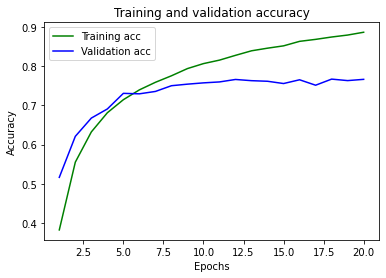

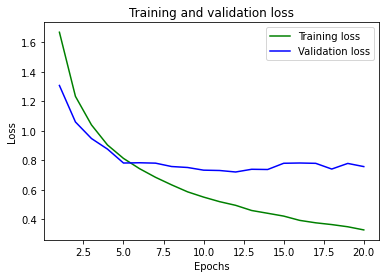

In [ ]:
import matplotlib.pyplot as plt

acc = clf['acc']
val_acc = clf['val_acc']
loss = clf['loss']
val_loss = clf['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Defining the Logistic regression model

Cross entropy loss has an inbuilt softmax function hence does need to be explicitly mentioned in the code below for the multiclass logistic regression problem.


In [ ]:

class Logistic_Regression(nn.Module):
    
    def __init__(self,num_classes):
        
        super(Logistic_Regression, self).__init__()
        self.Linear = nn.Linear(64*64*3,num_classes)
        
    def forward(self,x):
        
        x = x.reshape(-1, 64*64*3)
        x = self.Linear(x)
        
        return x   
        

# Initialising the Logistic regression model

In [ ]:
model1 = Logistic_Regression(num_classes = 10)

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

model1.to(device)

Logistic_Regression(
  (Linear): Linear(in_features=12288, out_features=10, bias=True)
)

# Using the Stochastic gradient regression optimizer and Cross entropy loss function

In [ ]:
learningRate = 0.001
optimizer = torch.optim.SGD(model1.parameters(), lr=learningRate)

In [ ]:
clf1 = train(model1, optimizer,torch.nn.CrossEntropyLoss(), train_ds,test_ds, epochs=100, device=device)

train() called: model=Logistic_Regression, opt=SGD(lr=0.001000), epochs=100, device=cuda

Epoch   1/100, train loss:  1.88, train acc:  0.35, val loss:  1.92, val acc:  0.32
Epoch   2/100, train loss:  1.80, train acc:  0.39, val loss:  1.90, val acc:  0.33
Epoch   4/100, train loss:  1.77, train acc:  0.40, val loss:  1.88, val acc:  0.34
Epoch   6/100, train loss:  1.75, train acc:  0.41, val loss:  1.87, val acc:  0.35
Epoch   8/100, train loss:  1.73, train acc:  0.41, val loss:  1.87, val acc:  0.35
Epoch  10/100, train loss:  1.72, train acc:  0.42, val loss:  1.86, val acc:  0.35
Epoch  12/100, train loss:  1.72, train acc:  0.42, val loss:  1.86, val acc:  0.35
Epoch  14/100, train loss:  1.71, train acc:  0.42, val loss:  1.86, val acc:  0.35
Epoch  16/100, train loss:  1.70, train acc:  0.42, val loss:  1.85, val acc:  0.36
Epoch  18/100, train loss:  1.70, train acc:  0.42, val loss:  1.85, val acc:  0.36
Epoch  20/100, train loss:  1.69, train acc:  0.43, val loss:  1.85, v

# Visualizing the results

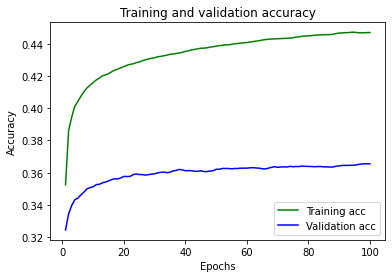

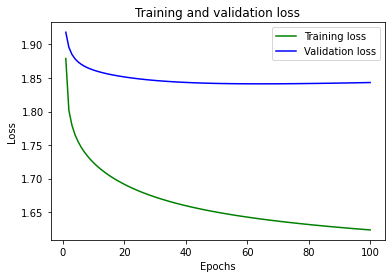

In [ ]:
acc = clf1['acc']
val_acc = clf1['val_acc']
loss = clf1['loss']
val_loss = clf1['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Summary of models

In [ ]:
from torchsummary import summary
print("Logistic Regression")
summary(model1, (3, 64, 64))
print("Convolution Neural Network")
summary(model,(3,64,64))

Convolution Neural Network
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]         122,890
Total params: 122,890
Trainable params: 122,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.00
Params size (MB): 0.47
Estimated Total Size (MB): 0.52
----------------------------------------------------------------
Logistic Regression
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
         MaxPool2d-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
              ReLU-5          [-1, 128, 32, 32]           